Лабораторная работа 3. Классификация. Нейронные сети

Цель работы: изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

Задачи:
1. Выбрать датасет, описать информацию о выбранном датасете, характеризовать признаки, провести предобработку данных.

2. Разбить данные на обучающий и тестовый наборы.

3. Построить классификационные модели с помощью пяти методов:

- наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

- деревья решений (Decision Tree);

- линейный дискриминантный анализ (Linear Discriminant Analysis);

- метод опорных векторов (Support Vector Machines);

- метод ближайших соседей (k-Nearest Neighbors).

4. Сравнить качество работы классификаторов с помощью следующих метрик:

- accuracy (точность),

- precision (доля правильно классифицированных положительных примеров),

- recall (чувствительность, доля верно найденных положительных примеров),

- F1-Score (среднее гармоническое precision и recall),

- площадь под кривой ROC (AUC-ROC).

5. Настроить гиперпараметры каждого метода и провести исследование влияния различных параметров на качество классификации.

6. Реализовать и протестировать нейронную сеть на TensorFlow, исследовать эффект настройки гиперпараметров и визуализировать процесс обучения с помощью инструмента TensorBoard.

Выбранный датасет: Iris dataset: Классификация видов цветов Iris. <br> <br>
Описание датасета: в датасет включены три вида ирисов по 50 образцов в каждом, а также некоторые свойства каждого цветка.

Столбцы в датасете: <br>
SepalLengthCm - Длина чашелистика (в см) <br>
SepalWidthCm - Ширина чашелистика (в см) <br>
PetalLengthCm - Длина лепестка (в см)<br>
PetalWidthCm - Ширина лепестка (в см) <br>
Species - Название вида - целевой признак <br>

1. Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import Binarizer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)


df = pd.read_csv('star_classification.csv')
df = df.replace('?', pd.NA).dropna()

# Определяем количество строк на каждый класс
samples_per_class = 10000 // 3  # ~3333

# Случайный шаффл (чтобы строки не были отсортированы по классам)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_dfs = []
for class_name in df_shuffled['class'].unique():
    class_subset = df_shuffled[df_shuffled['class'] == class_name].head(samples_per_class)
    balanced_dfs.append(class_subset)

df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['class'].value_counts())
df = df_balanced
#df = df.iloc[:-90000]

columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 
                   'field_ID', 'spec_obj_ID', 'fiber_ID']
df = df.drop(columns=columns_to_drop)
print(f"Размер: {df.shape}")
print(df.describe())


class
STAR      3333
QSO       3333
GALAXY    3333
Name: count, dtype: int64
Размер: (9999, 12)
             alpha        delta            u            g            r  \
count  9999.000000  9999.000000  9999.000000  9999.000000  9999.000000   
mean    178.277087    24.642663    21.761594    20.495187    19.719896   
std      97.965607    19.769580     2.166039     1.965812     1.827624   
min       0.013337   -17.284791    10.996230    10.511390    10.068540   
25%     124.825200     5.165229    20.208780    19.095570    18.457365   
50%     181.692764    24.962180    21.753680    20.874980    20.187320   
75%     236.416362    40.877418    23.233580    21.860610    21.097950   
max     359.999810    82.947622    29.234380    26.881750    27.397090   

                 i            z      cam_col     redshift         plate  \
count  9999.000000  9999.000000  9999.000000  9999.000000   9999.000000   
mean     19.277994    19.013666     3.509951     0.705991   5397.335234   
std       1.

In [2]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")


Асимметрия:
alpha               :   -0.012
delta               :    0.125
u                   :    0.012
g                   :   -0.424
r                   :   -0.650
i                   :   -0.551
z                   :   -0.463
cam_col             :   -0.027
redshift            :    1.788
plate               :    0.127
MJD                 :   -0.438

Эксцесс:
alpha               :   -0.616
delta               :   -1.099
u                   :   -0.283
g                   :   -0.077
r                   :   -0.054
i                   :   -0.062
z                   :   -0.190
cam_col             :   -1.114
redshift            :    4.640
plate               :   -0.968
MJD                 :   -0.699

Мода:
alpha               : 0.0133366618319997
delta               : -17.2847913705915
u                   : 24.63465
g                   : 16.82076
r                   : 20.54841
i                   : 19.64404
z                   : 22.8269
cam_col             : 4
redshift            : 0.0
pla

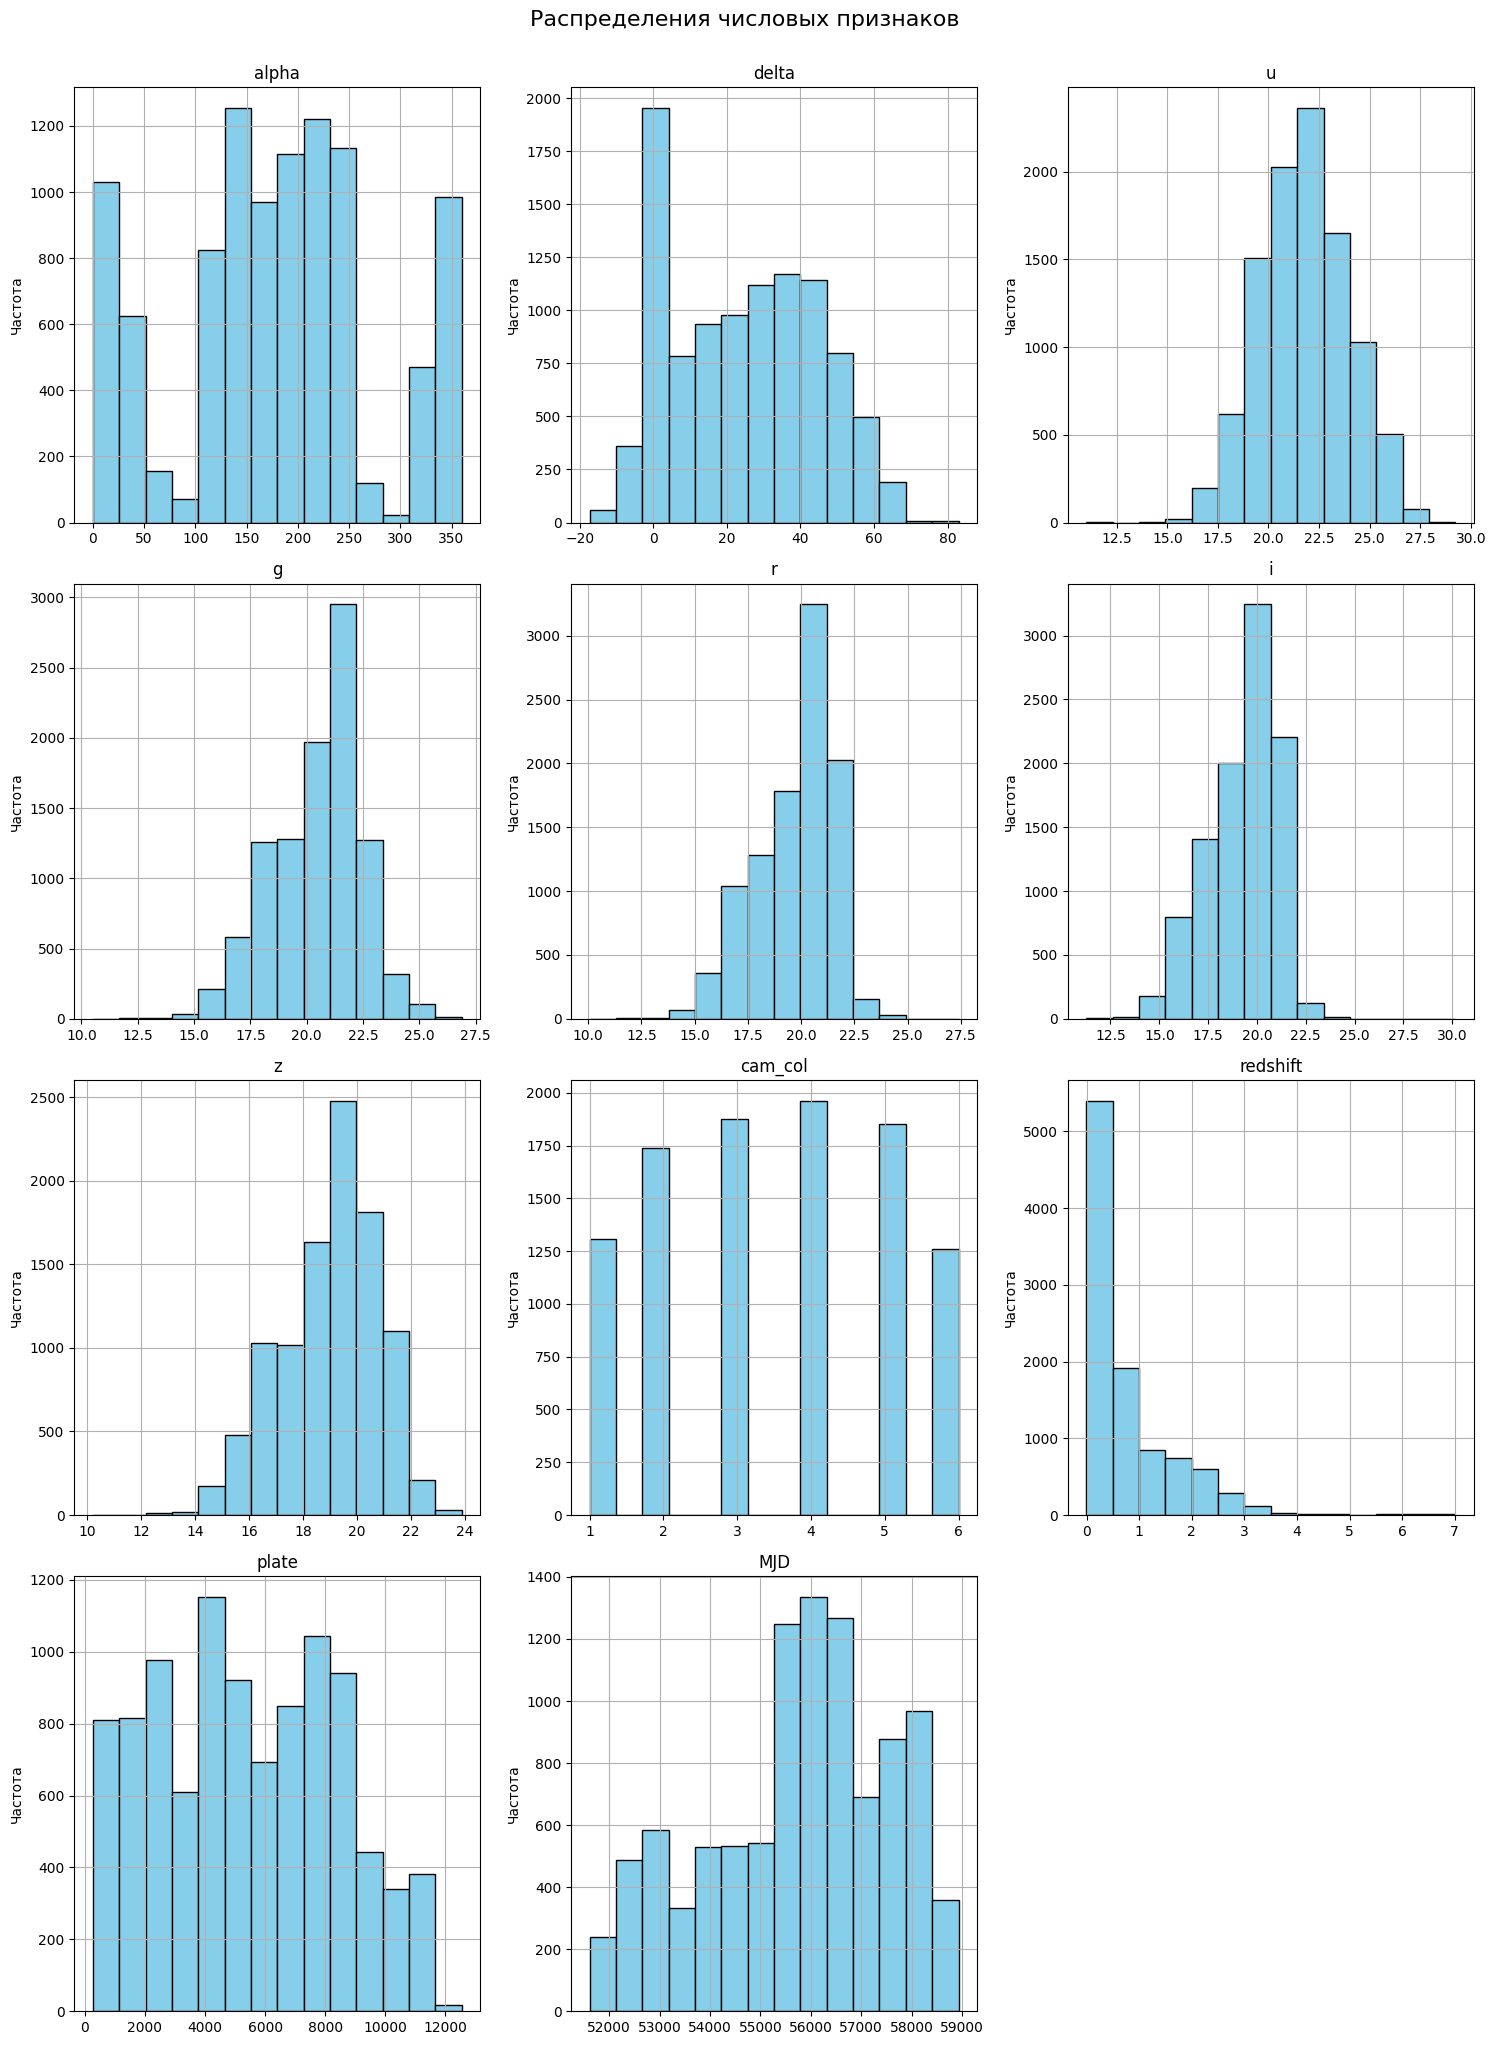

In [3]:
count_intervals = int(1 + math.log2(df.shape[0]))

n_features = len(numeric_columns)
n_subplot_cols = 3
n_subplot_rows = math.ceil(n_features / n_subplot_cols)  
fig, axes = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=(15, 5 * n_subplot_rows))
axes = axes.flatten() if n_subplot_rows > 1 else axes  
for i, col in enumerate(numeric_columns):
    df[col].hist(bins=count_intervals, ax=axes[i], 
                 color='skyblue', edgecolor='black')
    axes[i].set_title(col)  
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

In [4]:
le = LabelEncoder()
df['class_num'] = le.fit_transform(df['class'])
columns_to_drop = ['class']
df = df.drop(columns=columns_to_drop)

X = df.drop('class_num', axis=1)  
y = df['class_num']

numeric_features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD']
categorical_features = ['cam_col']  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) 
    ]
)

X_processed = preprocessor.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)
y_train_proba = gnb.predict_proba(X_train)
y_test_proba = gnb.predict_proba(X_test)

def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    print(f"=== Метрики для {dataset_name} ===")
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    auc = roc_auc_score(y_true, y_proba, average='macro', multi_class='ovr')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"AUC (macro, ovr): {auc:.4f}")
    print("-" * 30)


calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")

print("\nClassification Report (test):")
print(classification_report(y_test, y_test_pred, digits=4))



=== Метрики для обучающего множества ===
Accuracy: 0.7627
Precision (macro): 0.7692
Precision (micro): 0.7627
Recall (macro): 0.7627
Recall (micro): 0.7627
F1-score (macro): 0.7556
F1-score (micro): 0.7627
AUC (macro, ovr): 0.9039
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.7595
Precision (macro): 0.7658
Precision (micro): 0.7595
Recall (macro): 0.7595
Recall (micro): 0.7595
F1-score (macro): 0.7516
F1-score (micro): 0.7595
AUC (macro, ovr): 0.9033
------------------------------

Classification Report (test):
              precision    recall  f1-score   support

           0     0.8130    0.5557    0.6602       673
           1     0.7705    0.9026    0.8313       688
           2     0.7139    0.8200    0.7633       639

    accuracy                         0.7595      2000
   macro avg     0.7658    0.7595    0.7516      2000
weighted avg     0.7667    0.7595    0.7520      2000



Берем BernoulliNB. 
MultinomialNB и ComplementNB не подходят, так как требуют неотрицательные значения

In [6]:
pipe_default = Pipeline([
    ('binarizer', Binarizer(threshold=0.0)), 
    ('bnb', BernoulliNB())  
])

pipe_default.fit(X_train, y_train)

y_train_pred_default = pipe_default.predict(X_train)
y_test_pred_default = pipe_default.predict(X_test)
y_train_proba_default = pipe_default.predict_proba(X_train)
y_test_proba_default = pipe_default.predict_proba(X_test)

print("Модель с параметрами по умолчанию")
calculate_metrics(y_train, y_train_pred_default, y_train_proba_default, "обучающего множества")
calculate_metrics(y_test, y_test_pred_default, y_test_proba_default, "тестового множества")
print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_default, digits=4))

Модель с параметрами по умолчанию
=== Метрики для обучающего множества ===
Accuracy: 0.5606
Precision (macro): 0.6242
Precision (micro): 0.5606
Recall (macro): 0.5601
Recall (micro): 0.5606
F1-score (macro): 0.5769
F1-score (micro): 0.5606
AUC (macro, ovr): 0.7371
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.5670
Precision (macro): 0.6293
Precision (micro): 0.5670
Recall (macro): 0.5691
Recall (micro): 0.5670
F1-score (macro): 0.5870
F1-score (micro): 0.5670
AUC (macro, ovr): 0.7435
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.4387    0.5423    0.4850       673
           1     0.4701    0.5029    0.4860       688
           2     0.9792    0.6620    0.7899       639

    accuracy                         0.5670      2000
   macro avg     0.6293    0.5691    0.5870      2000
weighted avg     0.6222    0.5670    0.5828      2000



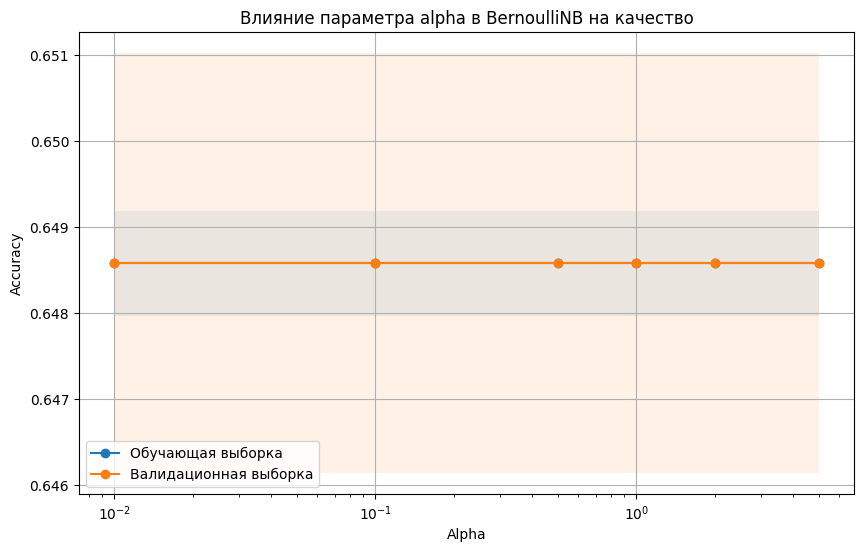

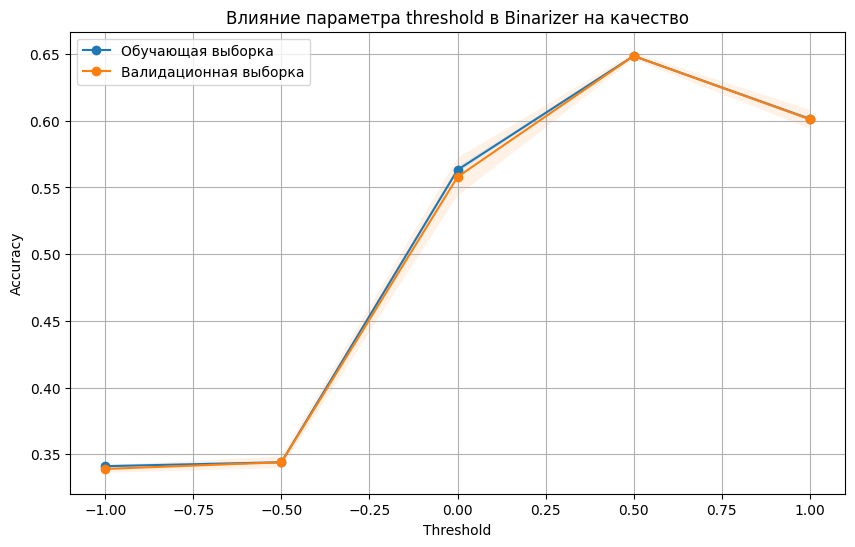

In [7]:
alpha_range = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]

pipe = Pipeline([
    ('binarizer', Binarizer(threshold=0.5)), 
    ('bnb', BernoulliNB())
])

train_scores, val_scores = validation_curve(
    pipe,                    
    X_train, y_train,        
    param_name='bnb__alpha', 
    param_range=alpha_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(alpha_range, train_mean, label='Обучающая выборка', marker='o')
plt.fill_between(alpha_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(alpha_range, val_mean, label='Валидационная выборка', marker='o')
plt.fill_between(alpha_range, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.title('Влияние параметра alpha в BernoulliNB на качество')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()





pipe = Pipeline([
    ('binarizer', Binarizer()),
    ('bnb', BernoulliNB(alpha=0.01))
])

threshold_range = [-1.0, -0.5, 0.0, 0.5, 1.0]

train_scores, val_scores = validation_curve(
    pipe,
    X_train, y_train,
    param_name='binarizer__threshold',
    param_range=threshold_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Среднее и стандартное отклонение
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, train_mean, label='Обучающая выборка', marker='o')
plt.fill_between(threshold_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(threshold_range, val_mean, label='Валидационная выборка', marker='o')
plt.fill_between(threshold_range, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.title('Влияние параметра threshold в Binarizer на качество')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Параметр alpha в BernoulliNB практически не влияет на качество классификации (accuracy), так как обучающая и валидационная кривые остаются стабильными в диапазоне [0.01, 5.0]. Это указывает на то, что модель устойчива к сглаживанию и не требует тонкой настройки этого гиперпараметра для данной задачи. 

Параметр threshold в Binarizer оказывает существенное влияние на качество классификации. Наилучшее значение Accuracy (≈0.65) достигается при threshold = 0.5. При более низких или высоких значениях порога качество снижается, что указывает на то, что оптимальная бинаризация данных важна для работы BernoulliNB. Это подтверждает необходимость подбора данного гиперпараметра.

In [8]:
pipe_best = Pipeline([
    ('binarizer', Binarizer(threshold=0.5)), 
    ('bnb', BernoulliNB(alpha=0.01))          
])

pipe_best.fit(X_train, y_train)

y_train_pred_best = pipe_best.predict(X_train)
y_test_pred_best = pipe_best.predict(X_test)
y_train_proba_best = pipe_best.predict_proba(X_train)
y_test_proba_best = pipe_best.predict_proba(X_test)

print("\nМодель с настроенными гиперпараметрами")
calculate_metrics(y_train, y_train_pred_best, y_train_proba_best, "обучающего множества")
calculate_metrics(y_test, y_test_pred_best, y_test_proba_best, "тестового множества")
print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_best, digits=4))




Модель с настроенными гиперпараметрами
=== Метрики для обучающего множества ===
Accuracy: 0.6486
Precision (macro): 0.4344
Precision (micro): 0.6486
Recall (macro): 0.6476
Recall (micro): 0.6486
F1-score (macro): 0.5192
F1-score (micro): 0.6486
AUC (macro, ovr): 0.7618
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.6465
Precision (macro): 0.4329
Precision (micro): 0.6465
Recall (macro): 0.6502
Recall (micro): 0.6465
F1-score (macro): 0.5185
F1-score (micro): 0.6465
AUC (macro, ovr): 0.7702
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       673
           1     0.6957    0.9506    0.8034       688
           2     0.6028    1.0000    0.7522       639

    accuracy                         0.6465      2000
   macro avg     0.4329    0.6502    0.5185      2000
weighted avg     0.4319    0.6465    0.5167      2000



c:\Документы\НГТУ\7 семестр\ИИ и машинное обучение\лабы\лаба 3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Документы\НГТУ\7 семестр\ИИ и машинное обучение\лабы\лаба 3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Документы\НГТУ\7 семестр\ИИ и машинное обучение\лабы\лаба 3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

In [ ]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

y_train_pred_dt_default = dt_default.predict(X_train)
y_test_pred_dt_default = dt_default.predict(X_test)
y_train_proba_dt_default = dt_default.predict_proba(X_train)
y_test_proba_dt_default = dt_default.predict_proba(X_test)

print("Дерево решений (по умолчанию)")
calculate_metrics(y_train, y_train_pred_dt_default, y_train_proba_dt_default, "обучающего множества")
calculate_metrics(y_test, y_test_pred_dt_default, y_test_proba_dt_default, "тестового множества")
print("\nClassification Report (test, default):")
print(classification_report(y_test, y_test_pred_dt_default, digits=4))

=== Дерево решений (по умолчанию) ===
=== Метрики для обучающего множества ===
Accuracy: 1.0000
Precision (macro): 1.0000
Precision (micro): 1.0000
Recall (macro): 1.0000
Recall (micro): 1.0000
F1-score (macro): 1.0000
F1-score (micro): 1.0000
AUC (macro, ovr): 1.0000
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9570
Precision (macro): 0.9578
Precision (micro): 0.9570
Recall (macro): 0.9577
Recall (micro): 0.9570
F1-score (macro): 0.9578
F1-score (micro): 0.9570
AUC (macro, ovr): 0.9680
------------------------------

Classification Report (test, default):
              precision    recall  f1-score   support

           0     0.9415    0.9331    0.9373       673
           1     0.9366    0.9448    0.9407       688
           2     0.9953    0.9953    0.9953       639

    accuracy                         0.9570      2000
   macro avg     0.9578    0.9577    0.9578      2000
weighted avg     0.9570    0.9570    0.9570      2000



In [ ]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Лучшие параметры для дерева:", grid_dt.best_params_)

Лучшие параметры для дерева: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучшая оценка (CV): 0.9617450750469043


In [ ]:
y_train_pred_dt_best = grid_dt.predict(X_train)
y_test_pred_dt_best = grid_dt.predict(X_test)
y_train_proba_dt_best = grid_dt.predict_proba(X_train)
y_test_proba_dt_best = grid_dt.predict_proba(X_test)

print("\n Дерево решений (с настроенными параметрами) ")
calculate_metrics(y_train, y_train_pred_dt_best, y_train_proba_dt_best, "обучающего множества")
calculate_metrics(y_test, y_test_pred_dt_best, y_test_proba_dt_best, "тестового множества")
print("\nClassification Report (test, best params):")
print(classification_report(y_test, y_test_pred_dt_best, digits=4))


=== Дерево решений (с настроенными параметрами) ===
=== Метрики для обучающего множества ===
Accuracy: 0.9747
Precision (macro): 0.9749
Precision (micro): 0.9747
Recall (macro): 0.9746
Recall (micro): 0.9747
F1-score (macro): 0.9746
F1-score (micro): 0.9747
AUC (macro, ovr): 0.9970
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.9645
Precision (macro): 0.9652
Precision (micro): 0.9645
Recall (macro): 0.9653
Recall (micro): 0.9645
F1-score (macro): 0.9651
F1-score (micro): 0.9645
AUC (macro, ovr): 0.9906
------------------------------

Classification Report (test, best params):
              precision    recall  f1-score   support

           0     0.9362    0.9599    0.9479       673
           1     0.9641    0.9360    0.9499       688
           2     0.9953    1.0000    0.9977       639

    accuracy                         0.9645      2000
   macro avg     0.9652    0.9653    0.9651      2000
weighted avg     0.9647    0.9645    0.9645      2000


Модель дерева решений с параметрами по умолчанию показала признаки сильного переобучения: точность на обучающей выборке составила 1.0, а на тестовой — 0.957. После настройки гиперпараметров (ограничение глубины, минимальное количество объектов в узле и листе), переобучение было уменьшено, а качество на тестовой выборке улучшилось до 0.9645.